In [37]:
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Step 1: Load the dataset
data = pd.read_csv("cleaned_wait_times.csv")  # Update the path as needed

# Step 2: Filter for only the selected Metric values
selected_metrics = ["Volume", "90th Percentile"]
filtered_data = data[data["Metric"].isin(selected_metrics)]

# Step 3: Pivot the dataset with selected metrics as columns
df_mod = filtered_data.pivot_table(
    index=["Reporting level", "Province", "Region", "Indicator", "Data year"],
    columns="Metric",
    values="Indicator result"
).reset_index()

# Step 4: Clean column names
df_mod.columns.name = None

# Step 5: Drop rows where all selected metrics are NaN
df_mod = df_mod.dropna(subset=selected_metrics, how='all')
df_mod.head()

,Reporting level,Province,Region,Indicator,Data year,90th Percentile,Volume
0,Provincial,Alberta,Calgary Zone,Bladder Cancer Surgery,2008,60.0,254.0
1,Provincial,Alberta,Calgary Zone,Bladder Cancer Surgery,2009,60.0,254.0
2,Provincial,Alberta,Calgary Zone,Bladder Cancer Surgery,2010,60.0,254.0
3,Provincial,Alberta,Calgary Zone,Bladder Cancer Surgery,2011,60.0,254.0
4,Provincial,Alberta,Calgary Zone,Bladder Cancer Surgery,2012,60.0,254.0


In [38]:
df_mod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3540 entries, 0 to 3539
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Reporting level  3540 non-null   object 
 1   Province         3540 non-null   object 
 2   Region           3540 non-null   object 
 3   Indicator        3540 non-null   object 
 4   Data year        3540 non-null   int64  
 5   90th Percentile  3540 non-null   float64
 6   Volume           3220 non-null   float64
dtypes: float64(2), int64(1), object(4)
memory usage: 193.7+ KB


In [40]:
# Create a combined grouping variable for random effects
# This treats each unique Province-Indicator combination as a group
df_mod['Province_Procedure'] = df_mod['Province'].astype(str) + '_' + df_mod['Indicator'].astype(str)

# --- 2. Define the Mixed Linear Model Formula ---
# Dependent variable: '90th Percentile'
# Fixed effects: 'Data year', 'Province', 'Indicator' (assuming 'Indicator' is the procedure type variable)
# Random effects: By default, mixedlm adds a random intercept for each group.
# 'C()' is used for categorical variables.
 # Fit the mixed model with random intercept + random slope for Year#
formula = 'Q("90th Percentile") ~ Q("Data year") + C(Province) + C(Indicator)'

# --- 3. Fit the Mixed Linear Model ---
# The 'groups' argument specifies the grouping variable for the random effects.
# In this case, we assume that wait times are correlated within each 'Province_Indicator' group over time.
model = smf.mixedlm(formula=formula, data=df_mod, groups=df_mod['Province_Procedure'])#,re_formula='Q("Data year")')
# --- 4. Print the Model Summary ---
model_result = model.fit()
print(model_result.summary())

                                       Mixed Linear Model Regression Results
Model:                             MixedLM                 Dependent Variable:                 Q("90th Percentile")
No. Observations:                  3540                    Method:                             REML                
No. Groups:                        140                     Scale:                              8050.0313           
Min. group size:                   16                      Log-Likelihood:                     -20936.2830         
Max. group size:                   196                     Converged:                          Yes                 
Mean group size:                   25.3                                                                            
-------------------------------------------------------------------------------------------------------------------
                                                              Coef.    Std.Err.    z    P>|z|   [0.025     0.97

In [41]:
# --- 5. Extract and Interpret the Results for 'Data Year' ---
print("\n--- Hypothesis Test Results for 'Data Year' (Mixed Model) ---")

# Access the fixed effects parameters table
fixed_effects_params = model_result.fe_params.to_frame(name='Coefficient')
fixed_effects_pvalues = model_result.pvalues.to_frame(name='P-value')
fixed_effects_results = pd.concat([fixed_effects_params, fixed_effects_pvalues], axis=1)

# The coefficient for 'Data year' will be labeled as such (e.g., 'Q("Data year")')
year_row_name = 'Q("Data year")'
if year_row_name in fixed_effects_results.index:
    year_p_value = fixed_effects_results.loc[year_row_name, 'P-value']
    year_coefficient = fixed_effects_results.loc[year_row_name, 'Coefficient']

    alpha = 0.05 # Significance level

    print(f"Coefficient for Data Year: {year_coefficient:.4f}")
    print(f"P-value for Data Year: {year_p_value:.4f}")
    print(f"Significance Level (alpha): {alpha}")

    if year_p_value < alpha:
        print("\nDecision: Reject the Null Hypothesis (H₀).")
        print(f"Conclusion: There is statistically significant evidence that 'Calendar Year' influences 'Wait Times' for priority procedures, after accounting for Province and Indicator (fixed effects) and within-group correlations (random effects). The coefficient ({year_coefficient:.4f}) indicates the estimated average change in wait times per year across all groups.")
        if year_coefficient > 0:
            print("Specifically, there is an increasing trend in wait times over the years.")
        else:
            print("Specifically, there is a decreasing trend in wait times over the years.")
    else:
        print("\nDecision: Fail to Reject the Null Hypothesis (H₀).")
        print("Conclusion: There is not enough statistically significant evidence to conclude that 'Calendar Year' influences 'Wait Times' for priority procedures in this mixed model.")
else:
    print(f"'{year_row_name}' not found in fixed effects results. Please check the column name in your data and the formula.")



--- Hypothesis Test Results for 'Data Year' (Mixed Model) ---
Coefficient for Data Year: 6.0332
P-value for Data Year: 0.0000
Significance Level (alpha): 0.05

Decision: Reject the Null Hypothesis (H₀).
Conclusion: There is statistically significant evidence that 'Calendar Year' influences 'Wait Times' for priority procedures, after accounting for Province and Indicator (fixed effects) and within-group correlations (random effects). The coefficient (6.0332) indicates the estimated average change in wait times per year across all groups.
Specifically, there is an increasing trend in wait times over the years.


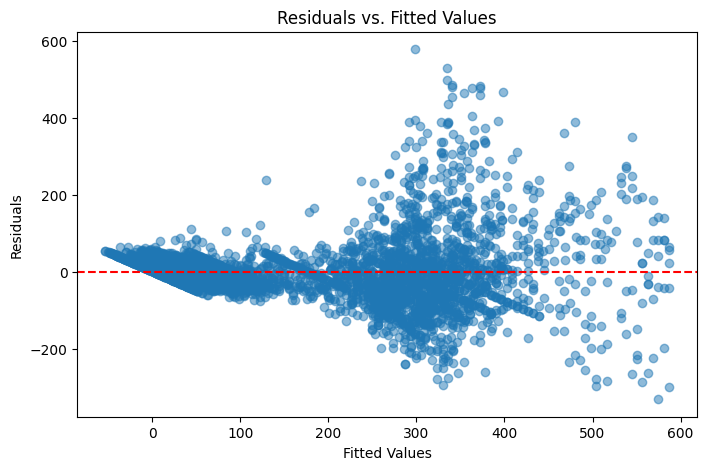

In [ ]:
#1. Residuals vs. Fitted Values (Linearity + Homoscedasticity)
fitted = model_result.fittedvalues
residuals = model_result.resid

plt.figure(figsize=(8, 5))
plt.scatter(fitted, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.show()


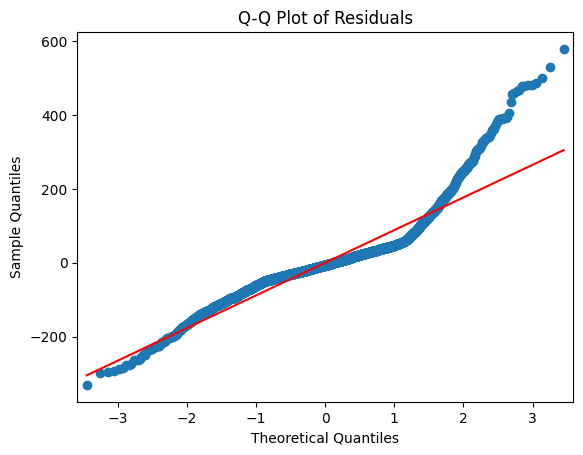

In [47]:
# 2. Q-Q Plot (Normality of Residuals
sm.qqplot(residuals, line='s')
plt.title("Q-Q Plot of Residuals")
plt.show()

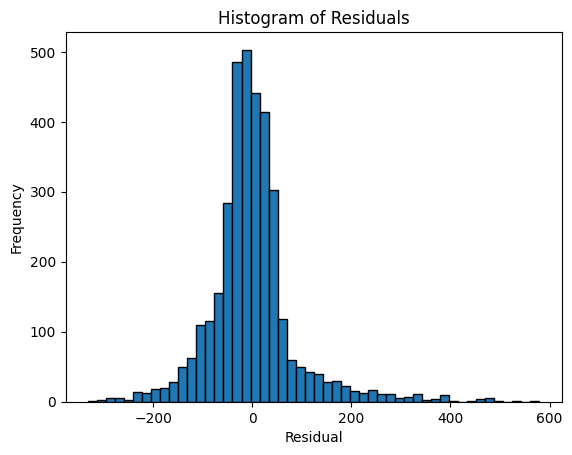

In [48]:
# 3. Histogram of Residuals
plt.hist(residuals, bins=50, edgecolor='k')
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.show()


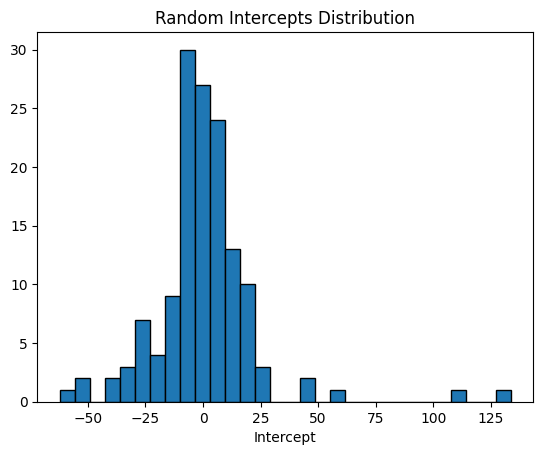

In [49]:
# Extract random effects
random_effects = model_result.random_effects

# Convert to DataFrame
re_df = pd.DataFrame.from_dict(random_effects, orient='index')

# Plot histogram of random intercepts
plt.hist(re_df.iloc[:, 0], bins=30, edgecolor='k')
plt.title("Random Intercepts Distribution")
plt.xlabel("Intercept")
plt.show()

# If you added random slopes (you did), plot slope distribution
if re_df.shape[1] > 1:
    plt.hist(re_df.iloc[:, 1], bins=30, edgecolor='k')
    plt.title("Random Slopes for Year")
    plt.xlabel("Year Slope")
    plt.show()


In [50]:
import numpy as np
df_mod["LogWaitTime"] = np.log(df_mod["90th Percentile"])
# 1. Update formula (keep fixed effects)
formula = 'Q("LogWaitTime") ~ Q("Data year") + C(Province) + C(Indicator)'

# 2. Fit the mixed model with random intercept + random slope for Year
model_2 = smf.mixedlm(
    formula=formula,
    data=df_mod,
    groups=df_mod['Province_Procedure']  # <-- this is key: random slope for Year
)

# 3. Fit the model
model_2_result = model.fit()

# 4. Print the summary
print(model_2_result.summary())

                                       Mixed Linear Model Regression Results
Model:                             MixedLM                 Dependent Variable:                 Q("90th Percentile")
No. Observations:                  3540                    Method:                             REML                
No. Groups:                        140                     Scale:                              8050.0313           
Min. group size:                   16                      Log-Likelihood:                     -20936.2830         
Max. group size:                   196                     Converged:                          Yes                 
Mean group size:                   25.3                                                                            
-------------------------------------------------------------------------------------------------------------------
                                                              Coef.    Std.Err.    z    P>|z|   [0.025     0.97

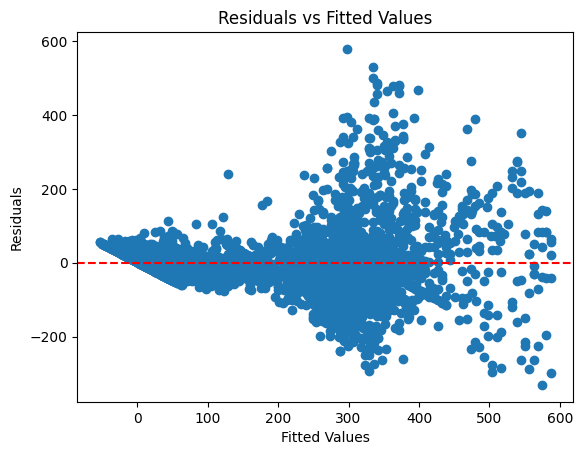

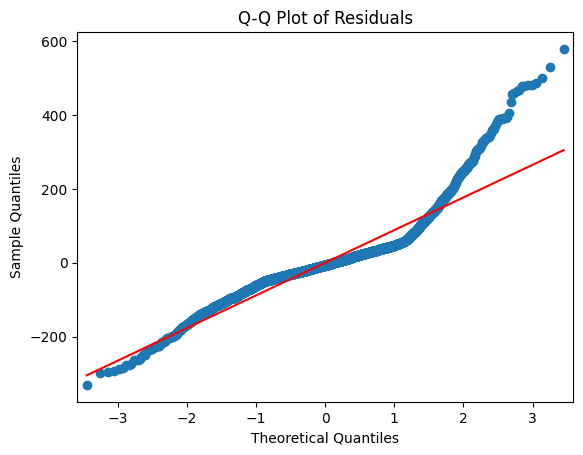

In [51]:
# Plot Residuals to check Assumptions
# Residuals vs. fitted values
plt.scatter(model_2_result.fittedvalues, model_2_result.resid)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Values")
plt.show()

# Q-Q plot of residuals
sm.qqplot(model_2_result.resid, line='s')
plt.title("Q-Q Plot of Residuals")
plt.show()